# Scikit learn models comparison

In this notebook different models are trained using the CommonCrawl dataset to study their performance.

In [1]:
# It is important to have the same version in Kaggle and in local
# to save and import the models properly
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import re
import string
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [4]:
df = pd.read_csv("/kaggle/input/all-codes-small.csv", na_filter=False)
df

,label,status_code,content_type,url,size,title,text
0,error,404,text/html,http://1ut8p3.com/product/aecphronian1201383?i...,1516,Domain misconfigured,Domain misconfigured\tThis domain points to Sh...
1,error,410,text/html,http://aka.justice.gov.uk/news/newsrelease0502...,2069,410 - Page Archived,410 - Page Archived\tMinistry of Justice\tThis...
2,error,404,text/html,http://aqwwiki.wikidot.com/paladin-ascendant-0-ac,25525,AQW,AQW\tHomepage\tNew Releases\tEncyclopedia\t+ W...
3,error,404,text/html,http://artikel-nolimitcity.online/3942972.phtml,48211,Page Not Found - Artikel Nolimit City,Page Not Found - Artikel Nolimit City\tSkip to...
4,error,406,text/html,http://bandongunclub.org/,251,406 Not Acceptable,406 Not Acceptable\tNot Acceptable\tAn appropr...
...,...,...,...,...,...,...,...
41193,content,200,text/html,https://wheat.pw.usda.gov/cgi-bin/cmap/feature...,53703,GrainGenes | A Database for Triticeae and Avena,GrainGenes | A Database for Triticeae and Aven...
41194,content,200,text/html,https://whenwedip.com/tag/harvard-bass/,80626,When We Dip | Harvard Bass Archives - When We Dip,When We Dip | Harvard Bass Archives - When We ...
41195,content,200,text/html,https://wherethereisdarkness.com/cgi-sys/suspe...,7642,Account Suspended,Account Suspended\tAccount Suspended\tThis Acc...
41196,content,200,text/html,https://whitecrowbooks.com/books/page/polterge...,26444,Poltergeists by Alan Gauld and A. D. Cornell |...,Poltergeists by Alan Gauld and A. D. Cornell |...


In [5]:
df.query("status_code != 200").shape[0]

20901

In [6]:
df.query("status_code == 200").shape[0]

20297

## Tokenization

Firs step is to tokenize the texts of dataset in order to retrieve the most relevant terms.

In [7]:
text_stream = [nltk.word_tokenize(d.lower()) for d in df.text.tolist()]

In [8]:
labels = df["label"].tolist()

In [9]:
# For some reason, nltk is not able to decompress 
# the wordnet corpora by itself, so let's help it
!unzip -n /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [10]:
def token_is_404(token):
    return token == "404"

def token_is_error_status_code(token):
    try:
        n = int(token)
        return 400 <= n <= 425 or 500 <= n <= 511
    except ValueError:
        return False

def token_is_punctuation(token):
    for c in token:
        if c not in string.punctuation:
            return False
    return True

def is_token_just_word(token):
    return re.match("^[a-z'_]+$", token)

def clean_term_sentence(ts):
    for token in ts:
        token = token.strip()
        token = token.replace("’", "'")
        if token and not token_is_punctuation(token) \
            and (is_token_just_word(token) or token_is_error_status_code(token)):
            yield WordNetLemmatizer().lemmatize(token)

clean_streams = [list(clean_term_sentence(ts)) for ts in text_stream]

In [11]:
documents = [" ".join(ts) for ts in clean_streams]
# print(documents[:10])

## Vectorization

The documents are transformed into vectors by using tf.idf.

In [12]:
my_vectorizer = TfidfVectorizer(
    analyzer='word', 
    max_features=30000,
    ngram_range=(1, 3)
)

X = my_vectorizer.fit_transform(documents)

doc_vectors = X.toarray()

## Training

In this section the document vectors are used to train the different models.

In [13]:
X_train, X_test, y_train, y_test  = train_test_split(
        doc_vectors, 
        labels,
        train_size=0.80,
        random_state=1234)

In [14]:
def show_metrics(model, y_true, y_pred):
    print("Model", model)
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {}".format(precision_score(y_true, y_pred, pos_label="error")))
    print("Recall: {}".format(recall_score(y_true, y_pred, pos_label="error")))
    print("F1: {}".format(f1_score(y_true, y_pred, pos_label="error")))
    
    labels = ['error', 'content']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                xticklabels=labels,
                yticklabels=labels)
    plt.ylabel('Actual', fontsize=13)
    plt.title('{} Confusion Matrix'.format(model), fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    # plt.gca().figure.subplots_adjust(bottom=0.2)
    # plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [15]:
def split_into_sublists_with_max_size(v, max_size):
    arrays = []
    start_offset = 0
    while True:
        subv = v[start_offset:start_offset+max_size]
        if len(subv) == 0:
            break
        arrays.append(subv)
        start_offset += max_size

    return arrays

In [16]:
nb_classifier = GaussianNB()

partials_X_train = split_into_sublists_with_max_size(X_train, 5000)
partials_y_train = split_into_sublists_with_max_size(y_train, 5000)

for partial_X_train, partial_y_train in zip(partials_X_train, partials_y_train):
    nb_classifier.partial_fit(
        partial_X_train, 
        partial_y_train, 
        np.unique(y_train)
    )



nb_y_pred = nb_classifier.predict(X_test)

Model GaussianNB
Accuracy: 0.9339805825242719
Precision: 0.9092131809011432
Recall: 0.966865315852205
F1: 0.9371534195933456


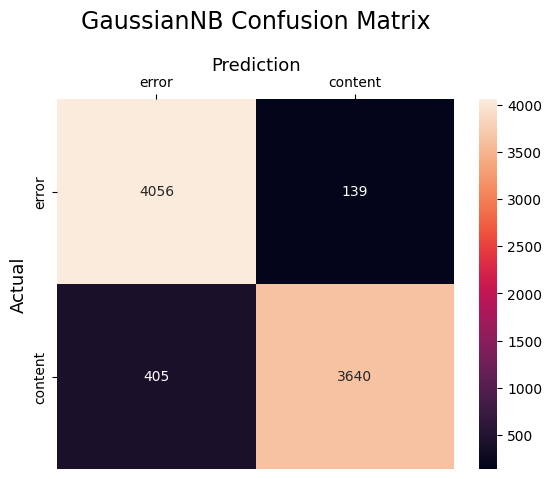

In [17]:
show_metrics("GaussianNB", y_test, nb_y_pred)

In [18]:
logreg_classifier = LogisticRegression()
logreg_model = logreg_classifier.fit(X=X_train, y=y_train)
logreg_y_pred = logreg_model.predict(X_test)

Model LogisticRegression
Accuracy: 0.975364077669903
Precision: 0.9947942488844819
Recall: 0.9566150178784267
F1: 0.9753311459472597


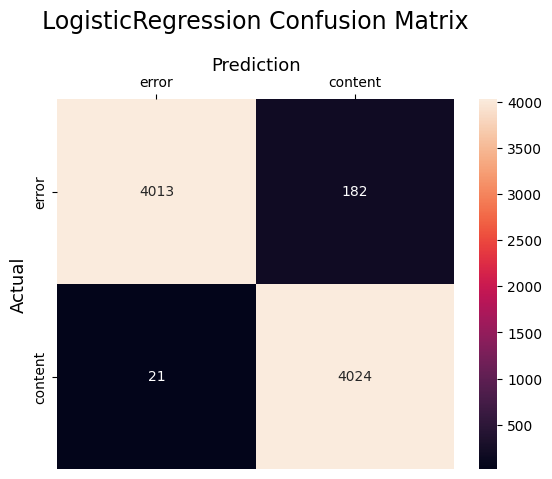

In [19]:
show_metrics("LogisticRegression", y_test, logreg_y_pred)

In [20]:
svc_model = LinearSVC()
svc_model.fit(X=X_train, y=y_train)
svc_y_pred = svc_model.predict(X_test)

Model LinearSVC
Accuracy: 0.9836165048543689
Precision: 0.9920019389238972
Recall: 0.9756853396901073
F1: 0.9837759884629251


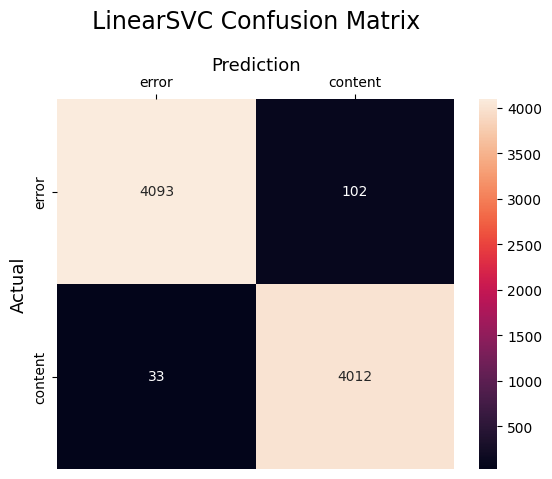

In [21]:
show_metrics("LinearSVC", y_test, svc_y_pred)

In [22]:
rf_classifier = RandomForestClassifier()
rf_model = rf_classifier.fit(X=X_train, y=y_train)
rf_y_pred = rf_model.predict(X_test)

Model RandomForest
Accuracy: 0.9811893203883495
Precision: 0.982560917343526
Recall: 0.9804529201430274
F1: 0.9815057868989381


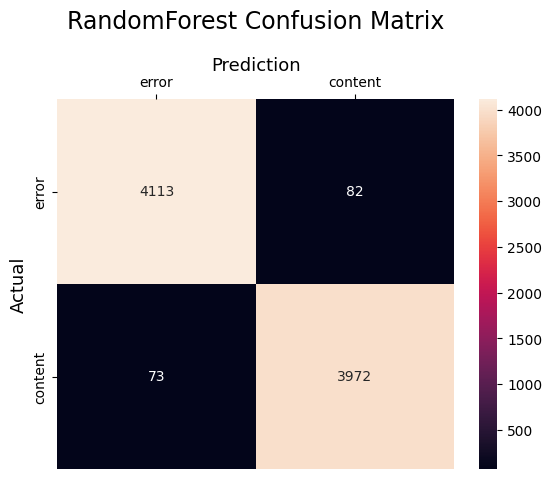

In [23]:
show_metrics("RandomForest", y_test, rf_y_pred)

## Models download

This section allows to download the trained models.

In [24]:
import pickle
from IPython.display import FileLink

def save_object_as_pickle(obj, filename):
    with open(filename, "wb") as fo:
        pickle.dump(obj, fo)

from datetime import datetime

date_part = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [25]:
filename = "tfidf-{}.pickle".format(date_part)
obj = my_vectorizer

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/tfidf-2024-12-26-22-43-01.pickle

In [26]:
filename = "nb-{}.pickle".format(date_part)
obj = nb_classifier

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/nb-2024-12-26-22-43-01.pickle

In [27]:
filename = "logreg-{}.pickle".format(date_part)
obj = logreg_model

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/logreg-2024-12-26-22-43-01.pickle

In [28]:
filename = "svc-{}.pickle".format(date_part)
obj = svc_model

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/svc-2024-12-26-22-43-01.pickle

In [29]:
filename = "rf-{}.pickle".format(date_part)
obj = rf_model

save_object_as_pickle(obj, filename)
FileLink(filename)

/kaggle/working/rf-2024-12-26-22-43-01.pickle

## Evaluation

In this section the models are evaluated against the manually labeled dataset.

In [30]:
def preprocess_test_dataset(csv_dataset, vectorizer):
    df = pd.read_csv(csv_dataset)
    # df["tag"] = df.status_code.map(lambda c: "error" if c != 200 else "content" )
    
    # Tokenize and clean tokens to generate the documents
    text_stream = [nltk.word_tokenize(d.lower()) for d in df.text.tolist()]
    
    clean_streams = [list(clean_term_sentence(ts)) for ts in text_stream]

    documents = [" ".join(ts) for ts in clean_streams]


    doc_vectors = vectorizer.transform(documents).toarray()
    labels = df["label"].tolist()

    return doc_vectors, labels

In [31]:
X_real, y_real = preprocess_test_dataset("/kaggle/input/dataset-test.csv", my_vectorizer) 

In [32]:
X_real

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Model GaussianNB
Accuracy: 0.6829268292682927
Precision: 0.6864406779661016
Recall: 0.7431192660550459
F1: 0.7136563876651982


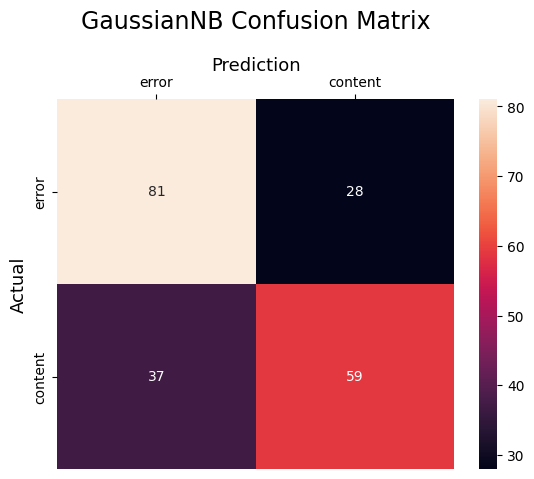

In [33]:
nb_y_real_pred = nb_classifier.predict(X_real)
show_metrics("GaussianNB", y_real, nb_y_real_pred)

Model LogisticRegression
Accuracy: 0.8634146341463415
Precision: 1.0
Recall: 0.7431192660550459
F1: 0.8526315789473684


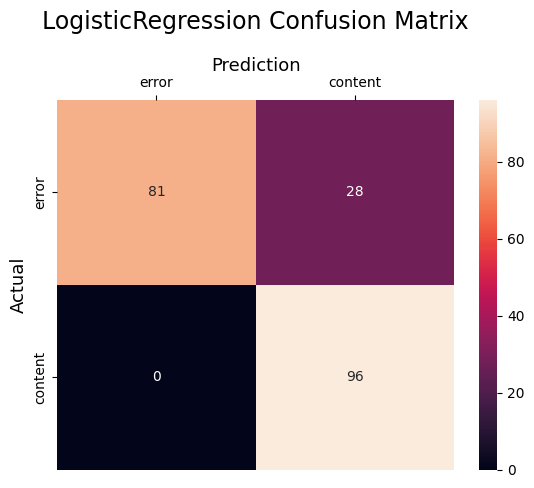

In [34]:
logreg_y_real_pred = logreg_model.predict(X_real)
show_metrics("LogisticRegression", y_real, logreg_y_real_pred)

Model LinearSVC
Accuracy: 0.8780487804878049
Precision: 1.0
Recall: 0.7706422018348624
F1: 0.8704663212435233


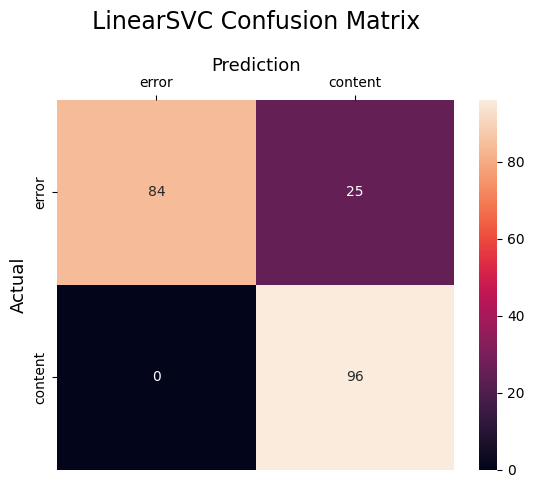

In [35]:
svc_y_real_pred = svc_model.predict(X_real)
show_metrics("LinearSVC", y_real, svc_y_real_pred)

Model RandomForest
Accuracy: 0.7560975609756098
Precision: 0.8041237113402062
Recall: 0.7155963302752294
F1: 0.7572815533980582


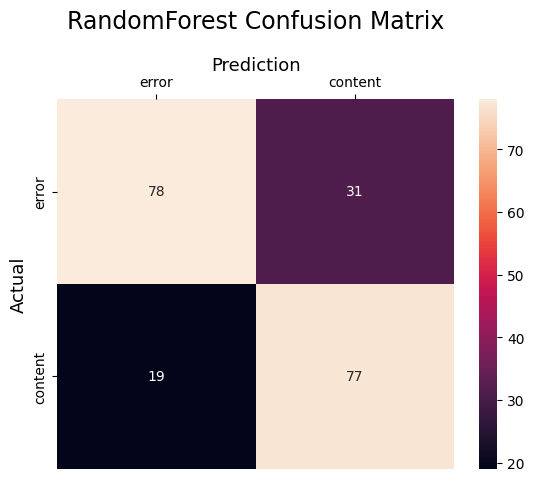

In [36]:
rf_y_real_pred = rf_model.predict(X_real)
show_metrics("RandomForest", y_real, rf_y_real_pred)

## Predictions study

After evaluating the models against the test dataset, a review of SVC predictions (the best performance model) is done in order to check if we can detect some pattern of errors to improve the labelling of the test dataset.

In [37]:
df_real = pd.read_csv("/kaggle/input/dataset-test.csv")
df_real["pred"] = svc_y_real_pred
df_real

,label,status_code,content_type,url,size,title,text,pred
0,content,200,text/html,https://1000uglypeople.com/e7aef43b-edde-490a-...,0,NaN,Loading...,content
1,content,200,text/html,https://500px.com/e7aef43b-edde-490a-a95f-a31d...,0,NaN,500px\tYou need to enable JavaScript to run th...,content
2,content,200,text/html,https://35awards.com/e7aef43b-edde-490a-a95f-a...,0,NaN,Annual photography contest 10th 35AWARDS - 100...,content
3,error,200,text/html,http://12121.hostinguk.com/e7aef43b-edde-490a-...,0,NaN,404 Error - Customer Page Not Found | Hosting UK,error
4,error,200,text/html,https://aaft.com/e7aef43b-edde-490a-a95f-a31d9...,0,NaN,html\tError! 404\tError! 404\tContact\tUs,error
...,...,...,...,...,...,...,...,...
200,error,200,text/html,https://theboreds.com/e7aef43b-edde-490a-a95f-...,0,NaN,Coming Soon\ttheboreds.com,error
201,error,200,text/html,https://www.theninja-rpg.com/e7aef43b-edde-490...,0,NaN,TheNinja-RPG.com - a free browser based mmorpg...,error
202,error,200,application/octet-stream,https://themarshallplan.net/e7aef43b-edde-490a...,0,NaN,themarshallplan.net\tthemarshallplan.net\tComi...,error
203,error,200,text/html,http://www.thespamletters.com/e7aef43b-edde-49...,0,NaN,Web Page Under Construction\tThis Site Is Unde...,error


In [38]:
df_diff = df_real.query("label != pred")
len(df_diff)

25

In [39]:
for index, row in df_diff.iterrows():
    print("Status code:", row["status_code"])
    print("Label:", row["label"])
    print("Predicted:", row["pred"])
    print("Content_type:", row["content_type"])
    print("URL:", row["url"])
    print("Text:\n{}".format(row["text"]))
    print("\n========================================\n")

Status code: 200
Label: error
Predicted: content
Content_type: text/html
URL: https://andyriga.wordpress.com/e7aef43b-edde-490a-a95f-a31d978d2bee
Text:
Private Site	Build a website. Sell your stuff. Write a blog. And so much more.	Log in	Start your website	Private Site	This site is currently private.	Log in to WordPress.com	to request access.


Status code: 200
Label: error
Predicted: content
Content_type: text/html
URL: https://aqicn.org/e7aef43b-edde-490a-a95f-a31d978d2bee
Text:
China Air Pollution: Real-time Air Quality Index (AQI)	home	Here	map	mask	faq	search	contact	links	404!	Enter a city name	↓ ↓ ↓	or let us find your nearest air quality monitoring station	Please wait while querying your location...	Previously visited stations:	About the Air Quality Levels	AQI	Air Pollution Level	Health Implications	Cautionary Statement (for PM2.5)	0 - 50	Good	Air quality is considered satisfactory, and air pollution poses little or no risk	None	51 -100	Moderate	Air quality is acceptable; howev

In [40]:
df_diff

,label,status_code,content_type,url,size,title,text,pred
12,error,200,text/html,https://andyriga.wordpress.com/e7aef43b-edde-4...,0,NaN,Private Site\tBuild a website. Sell your stuff...,content
15,error,200,text/html,https://aqicn.org/e7aef43b-edde-490a-a95f-a31d...,0,NaN,China Air Pollution: Real-time Air Quality Ind...,content
38,error,200,text/html,http://clubelo.com/e7aef43b-edde-490a-a95f-a31...,0,NaN,"Football Club Elo Ratings\t<\tSat, Dec 7th, 20...",content
48,error,200,text/html,https://dearreid.wordpress.com/e7aef43b-edde-4...,0,NaN,Private Site\tBuild a website. Sell your stuff...,content
55,error,200,text/html,https://dos.liquiddoom.net/e7aef43b-edde-490a-...,0,NaN,Cannot read from language file:\t./ai/language...,content
69,error,200,text/html,https://evolution.genetics.washington.edu/e7ae...,0,NaN,Felsenstein/Kuhner lab\tThese web pages have m...,content
83,error,200,text/html,https://furry.org.au/e7aef43b-edde-490a-a95f-a...,0,NaN,Find The Best Online Casinos in Australia\tIt ...,content
93,error,200,text/html,https://www.grandys.com/e7aef43b-edde-490a-a95...,0,NaN,jos-Error\t: Category not found\tJSite -> disp...,content
95,error,200,text/html,http://giantdatabase.com/e7aef43b-edde-490a-a9...,0,NaN,GiantDatabase.com Message Response,content
96,error,200,text/html,https://hags-club.com/e7aef43b-edde-490a-a95f-...,0,NaN,ACHTUNG!\tHAGS-CLUB.\tNET\tSCAM WARNING\tThe s...,content
